In [4]:
import pandas as pd
import geopandas as gpd
# If this doesn't work, substitute Infinity with 999.0 in the file
merged_data = gpd.read_file("MERGED_DATA.geojson")

# Preparing the merged data

In [11]:
merged_data.columns

Index(['blockgroup', 'year', 'month', 'prior_year', 'pri_neigh', 'Population',
       'pop_change', 'Median Income', 'income_change', 'Median Age',
       'age_change', 'WorkTransitCount', 'wt_count_change',
       'WorkTransitPercent', 'wt_perc_change', 'count_of_routes',
       'rt_count_change', 'MonthTotal', 'month-year', 'active', 'new',
       'prev_month-year', 'prev_yr_active', 'prev_yr_new', '%_change_active',
       '%_change_new', 'train_rides', 'geometry'],
      dtype='object')

In [72]:
df = merged_data.rename(columns={
    "MonthTotal": "bus_rides",
    "active": "active_biz_licenses",
    "new": "new_biz_licenses",
    "prev_yr_active": "prev_yr_active_biz_licenses",
    "prev_yr_new": "prev_yr_new_biz_licenses",
    "%_change_active": "%_change_active_biz_licenses",
    "%_change_new": "%_change_new_biz_licenses",
})

In [73]:
df = df.drop(columns=["month-year", "prev_month-year", "geometry"])
# this column is problematic due to the infinity values
# it could be useful but we need to decide what to do with those
df = df.drop(columns=["%_change_new_biz_licenses"])
df["total_transit_rides"] = df["bus_rides"] + df["train_rides"]

In [41]:
df.shape

(130704, 25)

In [51]:
df["year"].unique()

array([2018., 2017., 2016., 2015.,   nan])

In [52]:
df["prior_year"].unique()

array([2017., 2016., 2015., 2014.,   nan])

In [74]:
# get rid of filler rows
df = df[(~df["year"].isnull()) & (~df["month"].isnull())]
df["next_year"] = df["year"] + 1

In [59]:
df["year"].unique()

array([2018., 2017., 2016., 2015.])

In [75]:
# separate out previous years' rides
rides_per_month = df[
    ["blockgroup", "year", "month", "total_transit_rides"]
].rename(columns={
    "year": "next_year",
    "total_transit_rides": "next_transit_rides"
})
df = df.merge(rides_per_month, on=["blockgroup", "month", "next_year"])

In [76]:
# get rid of train and bus rides by themselves
df = df.drop(columns=["bus_rides", "train_rides"])
df = df[~df["next_transit_rides"].isnull()]
# compute change in rides
df["%_change_next_transit_rides"] = df["next_transit_rides"] / df["total_transit_rides"]
df.shape

(43264, 26)

In [179]:
df["year"].unique()

array([2017., 2016., 2015.])

In [84]:
# discretize ridership and change
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
dis1 = KBinsDiscretizer(n_bins=5, encode="ordinal")
next_rides = np.array(df["next_transit_rides"]).reshape(-1, 1)
dis1.fit(next_rides)
next_rides_quantiles = dis1.transform(next_rides)
df["next_transit_rides_quantiles"] = next_rides_quantiles

dis2 = KBinsDiscretizer(n_bins=5, encode="ordinal")
change_next_rides = np.array(df["%_change_next_transit_rides"]).reshape(-1, 1)
dis1.fit(change_next_rides)
change_next_rides_quantiles = dis1.transform(change_next_rides)
df["%_change_next_transit_rides_quantiles"] = change_next_rides_quantiles

In [176]:
df.dtypes

blockgroup                                object
year                                     float64
month                                    float64
prior_year                               float64
pri_neigh                                 object
Population                               float64
pop_change                               float64
Median Income                            float64
income_change                            float64
Median Age                               float64
age_change                               float64
WorkTransitCount                         float64
wt_count_change                          float64
WorkTransitPercent                       float64
wt_perc_change                           float64
count_of_routes                          float64
rt_count_change                          float64
active_biz_licenses                      float64
new_biz_licenses                         float64
prev_yr_active_biz_licenses              float64
prev_yr_new_biz_lice

# Preprocessing and Algorithms

In [183]:
# a lot of useful pipeline code from:
# https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

def make_preprocessor(df, columns):
    numeric_features = df[columns].select_dtypes(
        include=['int64', 'float64']
    ).drop(["month"], axis=1).columns
    transformers = [
        ('num', numeric_transformer, numeric_features),
    ]
    categorical_features = []
    if "pri_neigh" in columns:
        categorical_features.append("pri_neigh")
    if len(categorical_features) > 0:
        transformers.append(
            ('cat', categorical_transformer, categorical_features)
        )
    return ColumnTransformer(transformers=transformers), categorical_features

In [244]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

def linreg(df, columns, target_col, poly=False):
    """Runs a linear regression on df and returns MAE, MSE, R2.
    Set poly for polynomial features."""
    columns = columns.copy()
    X = df[columns].copy()
    y = df[target_col].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    preprocessor, categorical_features = make_preprocessor(df, columns)
    
    pipe_steps = [
        ('transform', preprocessor),
    ]
    if poly:
        pipe_steps.append((
            'polynomial',
            PolynomialFeatures(degree=2, include_bias=False)
        ))
    pipe_steps.append(('regression', LinearRegression()))
    pipe = Pipeline(steps=pipe_steps)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    if len(categorical_features) > 0:
        for col in categorical_features:
            columns.remove(col)
        cat_columns = pipe["transform"].transformers_[1][1]['onehot'].\
            get_feature_names(categorical_features)
        columns.extend(cat_columns)
    if poly:
        columns = pipe["polynomial"].get_feature_names(columns)
    return {
        "columns": columns,
        "best_estimator": pipe["regression"],
        "best_pipe": pipe,
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

def lasso_or_ridge(lasso_or_ridge, df, columns, target_col, alpha_vals, poly=False):
    """Runs a lasso or ridge regression on df and
    returns the best alpha, MAE, MSE, and R2.
    Uses grid search on alpha_vals with 5-fold validation.
    Set poly to use polynomial features."""
    columns = columns.copy()
    X = df[columns].copy()
    y = df[target_col].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    preprocessor, categorical_features = make_preprocessor(df, columns)
    
    pipe_steps = [
        ('transform', preprocessor),
    ]
    if poly:
        pipe_steps.append(('polynomial', PolynomialFeatures(degree=2, include_bias=False)))
    if lasso_or_ridge == "Lasso":
        pipe_steps.append(('regression', Lasso()))
    elif lasso_or_ridge == "Ridge":
        pipe_steps.append(('regression', Ridge()))
    pipe = Pipeline(steps=pipe_steps)
    
    param_grid = [{
        "regression__alpha": alpha_vals
    }]
    gs = GridSearchCV(pipe, scoring="r2", param_grid=param_grid, cv=5)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    
    best_pipe = gs.best_estimator_
    if len(categorical_features) > 0:
        for col in categorical_features:
            columns.remove(col)
        cat_columns = best_pipe["transform"].transformers_[1][1]['onehot'].\
            get_feature_names(categorical_features)
        columns.extend(cat_columns)
    if poly:
        columns = best_pipe["polynomial"].get_feature_names(columns)
    return {
        "columns": columns,
        "best_estimator": best_pipe["regression"],
        "best_pipe": best_pipe,
        "best_alpha": gs.best_params_["regression__alpha"],
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

def svm(df, columns, target_col, C_vals, poly=False):
    """Runs an SVM regression on df and
    returns the best params, MAE, MSE, and R2.
    Uses grid search with 5-fold validation on C_vals and linear/poly kernels.
    Set poly to use polynomial features."""
    columns = columns.copy()
    X = df[columns].copy()
    y = df[target_col].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    preprocessor, categorical_features = make_preprocessor(df, columns)
    
    pipe_steps = [
        ('transform', preprocessor),
    ]
    if poly:
        pipe_steps.append(('polynomial', PolynomialFeatures(degree=2, include_bias=False)))
    pipe_steps.append(('regression', SVR()))
    pipe = Pipeline(steps=pipe_steps)
    
    param_grid = [{
        "regression__C": C_vals,
        "regression__kernel": ["linear", "poly", "rbf"]
    }]
    gs = GridSearchCV(pipe, scoring="r2", param_grid=param_grid, cv=5)
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)
    
    best_pipe = gs.best_estimator_
    if len(categorical_features) > 0:
        for col in categorical_features:
            columns.remove(col)
        cat_columns = best_pipe["transform"].transformers_[1][1]['onehot'].\
            get_feature_names(categorical_features)
        columns.extend(cat_columns)
    if poly:
        columns = best_pipe["polynomial"].get_feature_names(columns)
    best_C = gs.best_params_["regression__C"]
    best_kernel = gs.best_params_["regression__kernel"]
    return {
        "columns": columns,
        "best_estimator": best_pipe["regression"],
        "best_pipe": best_pipe,
        "best_params": "kernel={},C={}".format(best_kernel, best_C),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Testing the Algorithms

Our testing regime is to split the data by year, then use 2015/2016 year's data to predict 2016/2017 ridership.

We train on 80% of the year's data, then output the MAE/MSE/$R^2$ for the other 20%.

Each test for Lasso/Ridge/SVM runs a grid search with 5-fold cross validation on hyperparameters.

In [210]:
df_2015 = df[df["year"] == 2015].copy()
df_2016 = df[df["year"] == 2016].copy()
df_2017 = df[df["year"] == 2017].copy()

feature_cols = [
    "month",
    "Population",
    "pop_change",
    "Median Income",
    "income_change",
    "Median Age",
    "age_change",
    "WorkTransitCount",
    "wt_count_change",
    "WorkTransitPercent",
    "wt_perc_change",
    "count_of_routes",
    "rt_count_change",
    "active_biz_licenses",
    "new_biz_licenses",
    "prev_yr_active_biz_licenses",
    "prev_yr_new_biz_licenses",
    "%_change_active_biz_licenses",
]

feature_cols_with_neigh = feature_cols + ["pri_neigh"]

In [297]:
missing_total = df[feature_cols_with_neigh].isnull().sum().sum()
total = df.shape[0] * df.shape[1]
print("Missing: {}/{} ({}%)".format(missing_total, total, (missing_total*100/total)))

Missing: 6768/1211392 (0.558696111580727%)


In [158]:
table = {
    "model": [],
    "year": [],
    "params": [],
    "MAE": [],
    "MSE": [],
    "R2": []
}
estimators = []

# linear regression
for poly in [False, True]:
    for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
        model_str = "LinearRegression"
        params_str = "poly={}".format(poly)
        print("{} ({}) {}".format(model_str, year, params_str))
        results = linreg(year_df, feature_cols_with_neigh, "next_transit_rides", poly)
        estimators.append({
            "columns": results["columns"],
            "estimator": results["best_estimator"]
        })
        table["model"].append(model_str)
        table["year"].append(year)
        table["params"].append(params_str)
        table["MAE"].append(results["MAE"])
        table["MSE"].append(results["MSE"])
        table["R2"].append(results["R2"])

display(pd.DataFrame(table))

LinearRegression (2015) poly=False
LinearRegression (2016) poly=False
LinearRegression (2015) poly=True
LinearRegression (2016) poly=True


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342


In [164]:
def show_most_important_features(estimators, idx, n):
    columns, estimator = estimators[idx]["columns"], estimators[idx]["estimator"]
    feature_df = pd.DataFrame({"feature": columns, "coef": estimator.coef_})
    feature_df = feature_df.set_index("feature").sort_values(by=["coef"], ascending=False)
    return feature_df.head(n)
show_most_important_features(estimators, 3, 10)

,coef
feature,
WorkTransitCount pri_neigh_West Loop,1.688021e+07
Median Age pri_neigh_West Loop,1.016057e+07
income_change pri_neigh_West Loop,8.832116e+06
WorkTransitPercent pri_neigh_West Loop,8.795900e+06
wt_count_change pri_neigh_West Loop,7.906946e+06
active_biz_licenses pri_neigh_West Loop,5.622191e+06
count_of_routes pri_neigh_Rush & Division,4.641239e+06
wt_count_change pri_neigh_Rush & Division,4.284354e+06
wt_count_change pri_neigh_Loop,4.225164e+06


In [163]:
# lasso and ridge regression; we don't use polynomial features for now
alpha_vals = [0.1, 1, 10, 100]
for regtype in ["Lasso", "Ridge"]:
    for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
        model_str = regtype + "Regression"
        print("{} ({}) poly=False".format(model_str, year))
        results = lasso_or_ridge(regtype, year_df, feature_cols_with_neigh, alpha_vals, "next_transit_rides")
        estimators.append({
            "columns": results["columns"],
            "estimator": results["best_estimator"]
        })
        table["model"].append(model_str)
        table["year"].append(year)
        table["params"].append("poly=False,alpha={}".format(results["best_alpha"]))
        table["MAE"].append(results["MAE"])
        table["MSE"].append(results["MSE"])
        table["R2"].append(results["R2"])

display(pd.DataFrame(table))

LassoRegression (2015) poly=False


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 427183166558820.6, tolerance: 564040662299.0126
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453097937529607.75, tolerance: 541926931380.64264
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 448162228589300.7, tolerance: 541105007284.1231
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7

LassoRegression (2016) poly=False


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450159465200384.5, tolerance: 553998860657.9849
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454654372744786.9, tolerance: 532500809660.3501
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439427011094990.44, tolerance: 531030483081.31445
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7

RidgeRegression (2015) poly=False
RidgeRegression (2016) poly=False


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
5,LassoRegression,2016,"poly=False,alpha=10",147463.103846,1.062556e+11,0.812116
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399


In [165]:
show_most_important_features(estimators, 6, 10)

,coef
feature,
pri_neigh_Loop,3.120124e+06
pri_neigh_River North,3.006894e+06
pri_neigh_Magnificent Mile,2.772064e+06
pri_neigh_Streeterville,2.626633e+06
pri_neigh_Printers Row,2.579801e+06
pri_neigh_Rush & Division,2.164311e+06
pri_neigh_Greektown,1.599530e+06
pri_neigh_Gold Coast,7.021669e+05
pri_neigh_Old Town,6.582035e+05


In [185]:
# linear regression without neighborhoods
for poly in [False, True]:
    for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
        model_str = "LinearRegression"
        params_str = "no_neigh,poly={}".format(poly)
        print("{} ({}) {}".format(model_str, year, params_str))
        results = linreg(year_df, feature_cols, "next_transit_rides", poly)
        estimators.append({
            "columns": results["columns"],
            "estimator": results["best_estimator"]
        })
        table["model"].append(model_str)
        table["year"].append(year)
        table["params"].append(params_str)
        table["MAE"].append(results["MAE"])
        table["MSE"].append(results["MSE"])
        table["R2"].append(results["R2"])

display(pd.DataFrame(table))

LinearRegression (2015) no_neigh,poly=False
LinearRegression (2016) no_neigh,poly=False
LinearRegression (2015) no_neigh,poly=True
LinearRegression (2016) no_neigh,poly=True


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
5,LassoRegression,2016,"poly=False,alpha=10",147463.103846,1.062556e+11,0.812116
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399
8,LinearRegression,2015,"no_neigh,poly=False",318408.104613,3.476403e+11,0.404098
9,LinearRegression,2016,"no_neigh,poly=False",318227.659995,3.353690e+11,0.406993


In [186]:
show_most_important_features(estimators, 11, 10)

,coef
feature,
new_biz_licenses,4.102910e+06
rt_count_change new_biz_licenses,1.157607e+06
WorkTransitCount new_biz_licenses,1.146659e+06
new_biz_licenses prev_yr_new_biz_licenses,9.483996e+05
age_change rt_count_change,6.157310e+05
age_change WorkTransitPercent,4.445882e+05
Median Age new_biz_licenses,4.383663e+05
wt_count_change rt_count_change,4.295088e+05
prev_yr_new_biz_licenses,3.948266e+05


In [231]:
# lasso and ridge regression without neighborhood
# we use polynomial features since it's a lot more tractable now
alpha_vals = [0.1, 1, 10, 100]
for regtype in ["Lasso", "Ridge"]:
    for poly in [False, True]:
        for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
            model_str = regtype + "Regression"
            print("{} ({}) no_neigh,poly={}".format(model_str, year, poly))
            results = lasso_or_ridge(regtype, year_df, feature_cols, "next_transit_rides", alpha_vals, poly)
            estimators.append({
                "columns": results["columns"],
                "estimator": results["best_estimator"]
            })
            table["model"].append(model_str)
            table["year"].append(year)
            table["params"].append("no_neigh,poly={},alpha={}".format(poly, results["best_alpha"]))
            table["MAE"].append(results["MAE"])
            table["MSE"].append(results["MSE"])
            table["R2"].append(results["R2"])

display(pd.DataFrame(table))

LassoRegression (2015) no_neigh,poly=False


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1655209986198066.8, tolerance: 564040662299.0126
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1620529203608915.5, tolerance: 541926931380.64264
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1591031328991473.0, tolerance: 541105007284.1231
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning

LassoRegression (2016) no_neigh,poly=False


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1601381242713398.5, tolerance: 532500809660.3501
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1561832567201708.8, tolerance: 531030483081.31445
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550623776679793.5, tolerance: 532757589952.42633
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarnin

LassoRegression (2015) no_neigh,poly=True


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1076920335108125.6, tolerance: 564040662299.0126
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1075772203119982.8, tolerance: 541926931380.64264
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1043956117649489.1, tolerance: 541105007284.1231
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning

LassoRegression (2016) no_neigh,poly=True


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006713912253141.6, tolerance: 553998860657.9849
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1011252432320378.2, tolerance: 532500809660.3501
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 962890539259780.5, tolerance: 531030483081.31445
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

RidgeRegression (2015) no_neigh,poly=False
RidgeRegression (2016) no_neigh,poly=False
RidgeRegression (2015) no_neigh,poly=True
RidgeRegression (2016) no_neigh,poly=True


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
5,LassoRegression,2016,"poly=False,alpha=10",147463.103846,1.062556e+11,0.812116
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399
8,LinearRegression,2015,"no_neigh,poly=False",318408.104613,3.476403e+11,0.404098
9,LinearRegression,2016,"no_neigh,poly=False",318227.659995,3.353690e+11,0.406993


In [232]:
# linear SVM with and without neighborhood
# without polynomial features
C_vals = [0.1, 1, 10, 100, 1000, 10000]
settings = [
    (False, feature_cols),
    (True, feature_cols_with_neigh)
]
for include_neigh, cols in settings:
    for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
        model_str = "SVM"
        params_str = ("no_neigh," if not include_neigh else "") + "poly=False"
        print("{} ({}) {}".format(model_str, year, params_str))
        results = svm(year_df, cols, "next_transit_rides", C_vals)
        print("R2 = {}".format(results["R2"]))
        estimators.append({
            "columns": results["columns"],
            "estimator": results["best_estimator"]
        })
        table["model"].append(model_str)
        table["year"].append(year)
        table["params"].append(params_str + "," + results["best_params"])
        table["MAE"].append(results["MAE"])
        table["MSE"].append(results["MSE"])
        table["R2"].append(results["R2"])

display(pd.DataFrame(table))

SVM (2015) no_neigh,poly=False
R2 = 0.34926373872873595
SVM (2016) no_neigh,poly=False
R2 = 0.3726718778734135
SVM (2015) poly=False
R2 = 0.5354845567279334
SVM (2016) poly=False
R2 = 0.5287546580601232


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
5,LassoRegression,2016,"poly=False,alpha=10",147463.103846,1.062556e+11,0.812116
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399
8,LinearRegression,2015,"no_neigh,poly=False",318408.104613,3.476403e+11,0.404098
9,LinearRegression,2016,"no_neigh,poly=False",318227.659995,3.353690e+11,0.406993


In [237]:
# utility function
def remove_last_n_from_table(table, n):
    table["model"] = table["model"][:-n]
    table["year"] = table["year"][:-n]
    table["params"] = table["params"][:-n]
    table["MAE"] = table["MAE"][:-n]
    table["MSE"] = table["MSE"][:-n]
    table["R2"] = table["R2"][:-n]
    return table
# table = remove_last_n_from_table(table, 3)

In [236]:
# one last try: ridge and lasso regression with polynomial features
alpha_vals = [0.1, 1, 10, 100]
for regtype in ["Lasso", "Ridge"]:
    for year, year_df in zip([2015, 2016], [df_2015, df_2016]):
        model_str = regtype + "Regression"
        print("{} ({}) poly=True".format(model_str, year))
        results = lasso_or_ridge(
            regtype,
            year_df,
            feature_cols_with_neigh,
            "next_transit_rides",
            alpha_vals,
            True,
        )
        estimators.append(
            {"columns": results["columns"], "estimator": results["best_estimator"]}
        )
        table["model"].append(model_str)
        table["year"].append(year)
        table["params"].append("poly=True,alpha={}".format(results["best_alpha"]))
        table["MAE"].append(results["MAE"])
        table["MSE"].append(results["MSE"])
        table["R2"].append(results["R2"])

display(pd.DataFrame(table))

LassoRegression (2015) poly=True


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42020471104875.03, tolerance: 564040662299.0126
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42216773934441.81, tolerance: 541926931380.64264
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41863146957203.195, tolerance: 541105007284.1231
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7

LassoRegression (2016) poly=True


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51673561301788.945, tolerance: 553998860657.9849
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50737956448931.26, tolerance: 532500809660.3501
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49669469154662.0, tolerance: 531030483081.31445
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/

RidgeRegression (2015) poly=True
RidgeRegression (2016) poly=True


,model,year,params,MAE,MSE,R2
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
1,LinearRegression,2016,poly=False,147509.471338,1.062848e+11,0.812065
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
5,LassoRegression,2016,"poly=False,alpha=10",147463.103846,1.062556e+11,0.812116
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399
8,LinearRegression,2015,"no_neigh,poly=False",318408.104613,3.476403e+11,0.404098
9,LinearRegression,2016,"no_neigh,poly=False",318227.659995,3.353690e+11,0.406993


In [238]:
display(pd.DataFrame(table).sort_values(by=["R2"], ascending=False))

,model,year,params,MAE,MSE,R2
2,LinearRegression,2015,poly=True,55422.601880,8.112648e+09,0.986094
3,LinearRegression,2016,poly=True,59986.259145,9.420937e+09,0.983342
24,LassoRegression,2015,"poly=True,alpha=10",66891.395718,1.257304e+10,0.978448
25,LassoRegression,2016,"poly=True,alpha=10",73948.165007,1.619624e+10,0.971361
26,RidgeRegression,2015,"poly=True,alpha=0.1",91983.950617,2.217137e+10,0.961995
27,RidgeRegression,2016,"poly=True,alpha=0.1",93861.079981,2.496923e+10,0.955849
6,RidgeRegression,2015,"poly=False,alpha=0.1",150983.693716,1.080926e+11,0.814715
4,LassoRegression,2015,"poly=False,alpha=10",150799.642818,1.083244e+11,0.814318
0,LinearRegression,2015,poly=False,150863.062858,1.083373e+11,0.814295
7,RidgeRegression,2016,"poly=False,alpha=0.1",147897.301139,1.060955e+11,0.812399


# Best Estimators

With neighborhoods:

1. Linear Regression (with polynomial features)
2. Lasso Regression (with polynomial features, $\alpha = 10$)

Without neighborhoods:

1. Linear Regression (with polynomial features)
2. Lasso Regression (with polynomial features, $\alpha = 100$)

We test these remaining few on the 2017 data (predicting 2018 ridership).

In [248]:
test_table = {"model": [], "params": [], "MAE": [], "MSE": [], "R2": []}
test_estimators = []

def handle_results(model_str, results, include_neigh):
    test_estimators.append(
        {"columns": results["columns"],
         "estimator": results["best_estimator"],
         "pipe": results["best_pipe"]}
    )
    test_table["model"].append(model_str)
    param_str = "no_neigh," if not include_neigh else ""
    if "best_alpha" in results:
        param_str += "alpha={}".format(results["best_alpha"])
    test_table["params"].append(param_str)
    test_table["MAE"].append(results["MAE"])
    test_table["MSE"].append(results["MSE"])
    test_table["R2"].append(results["R2"])


def test_linreg(train_df, test_df, target_col, settings):
    for include_neigh, cols in settings:
        X_test = test_df[cols].copy()
        y_test = test_df[target_col].copy()
        model_str = "LinearRegression"
        print("{} (final test), include_neigh={}".format(model_str, include_neigh))
        results = linreg(train_df, cols, target_col, True,)
        pipe = results["best_pipe"]
        y_pred = pipe.predict(X_test)
        test_results = {
            "columns": results["columns"],
            "best_estimator": results["best_estimator"],
            "best_pipe": pipe,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R2": r2_score(y_test, y_pred),
        }
        handle_results(model_str, test_results, include_neigh)

def test_lasso(train_df, test_df, target_col, lasso_settings):
    for include_neigh, cols, alpha in lasso_settings:
        X_test = test_df[cols].copy()
        y_test = test_df[target_col].copy()
        model_str = "LassoRegression"
        print("{} (final test), include_neigh={}".format(model_str, include_neigh))
        results = lasso_or_ridge("Lasso", train_df, cols, target_col, [alpha], True,)
        pipe = results["best_pipe"]
        y_pred = pipe.predict(X_test)
        test_results = {
            "columns": results["columns"],
            "best_estimator": results["best_estimator"],
            "best_pipe": pipe,
            "best_alpha": alpha,
            "MAE": mean_absolute_error(y_test, y_pred),
            "MSE": mean_squared_error(y_test, y_pred),
            "R2": r2_score(y_test, y_pred),
        }
        handle_results(model_str, test_results, include_neigh)

df_2015_2016 = pd.concat([df_2015, df_2016])
settings = [(False, feature_cols), (True, feature_cols_with_neigh)]
lasso_settings = [(False, feature_cols, 100), (True, feature_cols_with_neigh, 10)]

test_linreg(df_2015_2016, df_2017, "next_transit_rides", settings)
test_lasso(df_2015_2016, df_2017, "next_transit_rides", lasso_settings)

LinearRegression (final test), include_neigh=False
LinearRegression (final test), include_neigh=True
LassoRegression (final test), include_neigh=False


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1838569053051953.2, tolerance: 1090186897981.1305
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2060332477802283.0, tolerance: 1059303516062.0857
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1826847694428101.0, tolerance: 1098661259530.618
  positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarnin

LassoRegression (final test), include_neigh=True


/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188323810582348.25, tolerance: 1090186897981.1305
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180975256115215.38, tolerance: 1059303516062.0857
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189020888983895.0, tolerance: 1098661259530.618
  max_iter, tol, rng, random, positive)
/Users/rk/opt/anaconda3/envs/finalxd/lib/python3

In [249]:
display(pd.DataFrame(test_table))

,model,params,MAE,MSE,R2
0,LinearRegression,"no_neigh,",338471.296968,3.233768e+11,0.493348
1,LinearRegression,,133138.513114,7.385188e+10,0.884292
2,LassoRegression,"no_neigh,alpha=100",336573.567114,3.205847e+11,0.497723
3,LassoRegression,alpha=10,121817.668543,5.860439e+10,0.908181


In [259]:
pd.DataFrame(table).sort_values(by=["R2"], ascending=False).to_csv("TestResults_Initial_2015-2016.csv")
pd.DataFrame(test_table).sort_values(by=["R2"], ascending=False).to_csv("TestResults_Final_2017.csv")

# Evaluating Features and t-test

,age_change rt_count_change,age_change,Median Income new_biz_licenses,age_change WorkTransitPercent,wt_count_change rt_count_change,age_change WorkTransitCount,wt_count_change wt_perc_change,Median Income rt_count_change,wt_count_change new_biz_licenses,age_change new_biz_licenses
coef,437251.608136,314793.820118,269983.19934,201973.428085,195306.425989,-184340.180287,-232365.67469,-287402.246085,-302357.32676,-372058.221749


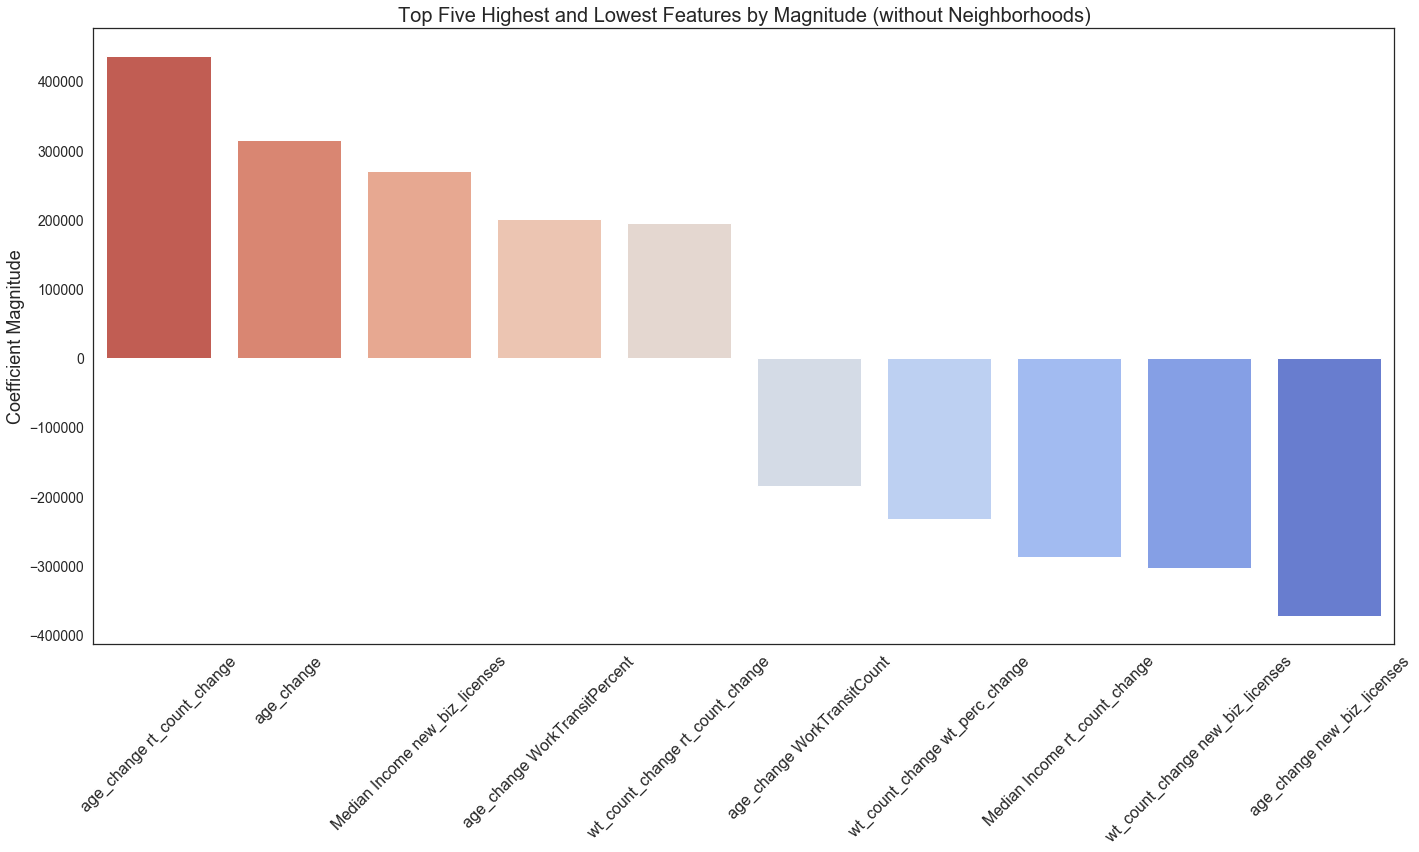

,pri_neigh_Logan Square,pri_neigh_Printers Row,pri_neigh_Portage Park^2,pri_neigh_Sheffield & DePaul,pri_neigh_Portage Park,pop_change pri_neigh_Logan Square,Population pri_neigh_West Lawn,month pri_neigh_West Lawn,age_change pri_neigh_Grant Park,rt_count_change pri_neigh_West Lawn
coef,3.195450e+06,3.002129e+06,2.759828e+06,2.689608e+06,2.633960e+06,-695042.897833,-779939.585623,-843129.2004,-1.084077e+06,-1.190958e+06


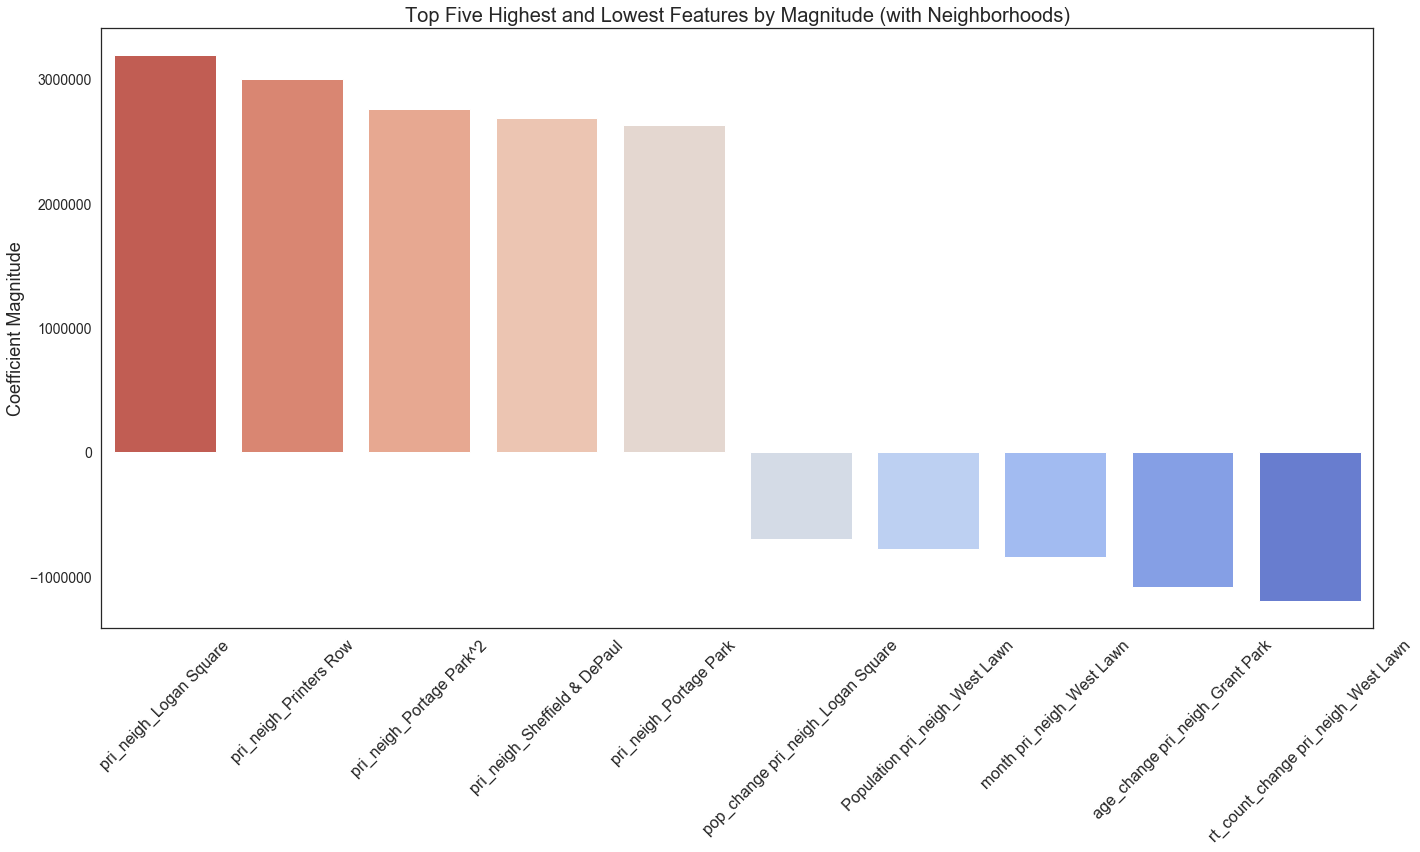

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# Feature importance
def feature_importance(best_model, columns, title, filename):
    features = pd.DataFrame([best_model.coef_], columns=columns, index=["coef"])
    top_features = features.T.sort_values(by="coef", ascending=False)
    top_ten = pd.concat((top_features.head(5), top_features.tail(5))).T
    display(top_ten)

    sns.set(style="white", rc={"figure.figsize": (20, 12)})

    ax = sns.barplot(data=top_ten, palette="coolwarm_r")

    plt.title(title, fontsize=20)
    plt.ylabel("Coefficient Magnitude", fontsize=18)
    plt.xlabel("")

    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show(ax)


feature_importance(
    test_estimators[2]["estimator"],
    test_estimators[2]["columns"],
    "Top Five Highest and Lowest Features by Magnitude (without Neighborhoods)",
    "viz/FeatureImportance_Lasso_NoNeighborhoods.png",
)

feature_importance(
    test_estimators[3]["estimator"],
    test_estimators[3]["columns"],
    "Top Five Highest and Lowest Features by Magnitude (with Neighborhoods)",
    "viz/FeatureImportance_Lasso_Neighborhoods.png",
)

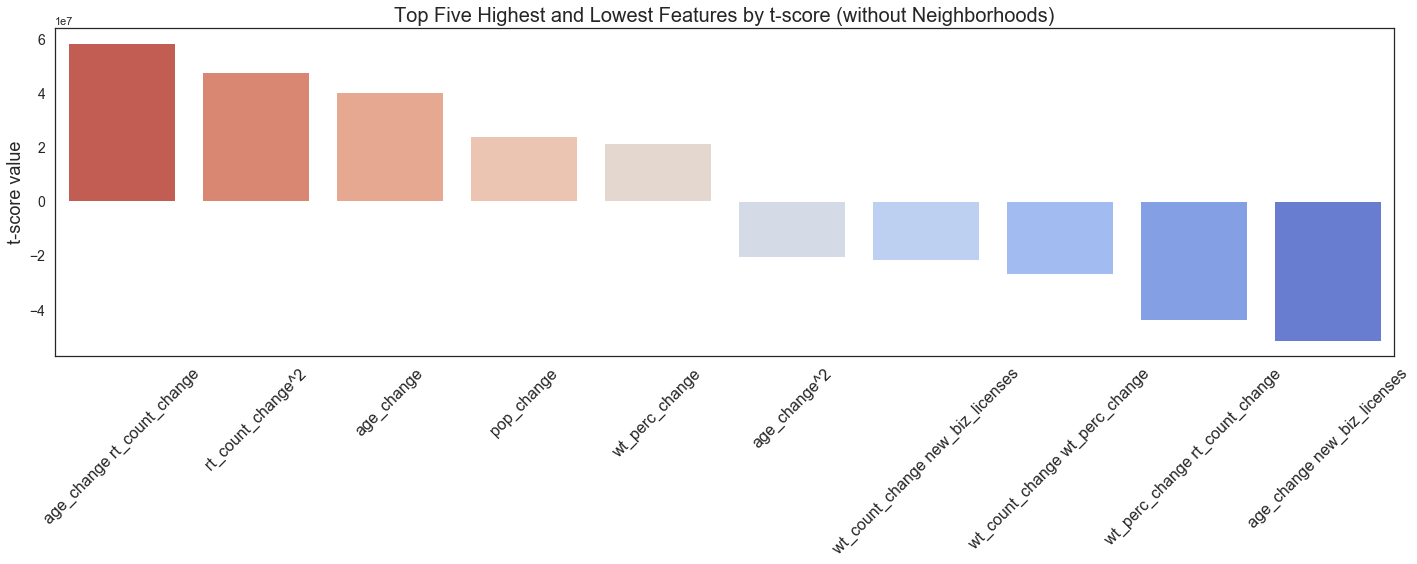

/Users/rk/opt/anaconda3/envs/finalxd/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


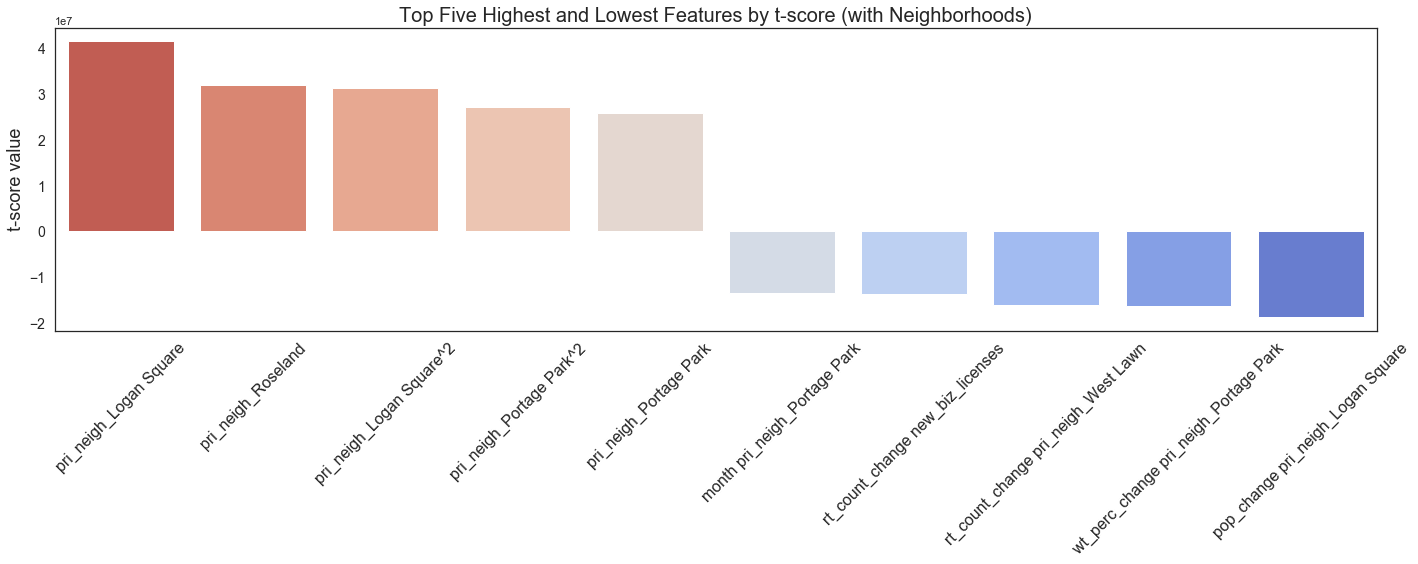

In [290]:
# t-test
from scipy.sparse import csr_matrix


def t_scores(y_hat, y, x_test, model):
    """
    Function to compute t-scores for model.
    Based on https://gist.github.com/brentp/5355925
    Accessed 4/30/2020.

    uses formulas:
    t = coef - 0 / std err
    std err = sqrt(sum of sq err / sample var)
    sum of sq err = (y-hat - y)^2 / n - p

    """
    sse = np.sum((y_hat - y) ** 2, axis=0) / float(x_test.shape[0] - x_test.shape[1])

    # sometimes sklearn gives us a sparse matrix,
    # so we need to convert it to a numpy array
    if isinstance(x_test, csr_matrix):
        x_test = x_test.toarray()
    xTx = np.dot(x_test.T, x_test)
    # sometimes the sample variance for a feature is zero, so 1/var doesn't compute.
    # this means we can't simply invert xTx to get 1/var
    sample_var = np.diagonal(xTx)
    shape = sample_var.shape
    # inv_sample_var is 1/var except when var = 0, in which case we set it to 0
    inv_sample_var = np.divide(
        np.ones(shape, dtype=float),
        sample_var,
        out=np.zeros(shape, dtype=float),
        where=(sample_var != 0),
    )
    se = np.array([np.sqrt(inv_sample_var)])

    t = model.coef_ / se

    return t


def plot_t_scores(
    best_pipe, columns, test_df, orig_feature_cols, target_col, title, filename
):
    best_model = best_pipe["regression"]
    X_test = test_df[orig_feature_cols].copy()
    y_test = test_df[target_col].copy()

    y_pred = best_pipe.predict(X_test)
    X_test_preprocessed = best_pipe["transform"].transform(X_test)
    X_test_poly = best_pipe["polynomial"].transform(X_test_preprocessed)

    # get scores
    t_vals = t_scores(y_pred, y_test, X_test_poly, best_model)

    x_test_poly_df = pd.DataFrame([best_model.coef_], columns=columns)

    # iterate over t_val array and add coefiecients and significance
    t_score_df = {"coef": [], "t_score": [], "sig": []}

    for n, var in enumerate(x_test_poly_df.columns):
        score = t_vals[0][n]
        sig = abs(score) > 2.0

        t_score_df.get("coef", []).append(var)
        t_score_df.get("t_score", []).append(score)
        t_score_df.get("sig", []).append(sig)

    t_score_df = pd.DataFrame(t_score_df)

    # vizualize top ten
    top_ten_t_scores = pd.concat(
        (
            t_score_df[t_score_df["sig"] == True]
            .sort_values(by="t_score", ascending=False)
            .head(),
            t_score_df[t_score_df["sig"] == True]
            .sort_values(by="t_score", ascending=False)
            .tail(),
        )
    )

    sns.set(style="white", rc={"figure.figsize": (20, 8)})

    ax = sns.barplot(x="coef", y="t_score", data=top_ten_t_scores, palette="coolwarm_r")

    plt.title(title, fontsize=20)
    plt.ylabel("t-score value", fontsize=18)
    plt.xlabel("")

    plt.xticks(rotation=45, fontsize=16)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show(ax)


plot_t_scores(
    test_estimators[2]["pipe"],
    test_estimators[2]["columns"],
    df_2017,
    feature_cols,
    "next_transit_rides",
    "Top Five Highest and Lowest Features by t-score (without Neighborhoods)",
    "viz/t_scores_Lasso_NoNeighborhoods.png",
)

plot_t_scores(
    test_estimators[3]["pipe"],
    test_estimators[3]["columns"],
    df_2017,
    feature_cols_with_neigh,
    "next_transit_rides",
    "Top Five Highest and Lowest Features by t-score (with Neighborhoods)",
    "viz/t_scores_Lasso_Neighborhoods.png",
)


In [302]:
pred_2017 = test_estimators[2]["pipe"].predict(df_2017[feature_cols])
df_2017["predicted_transit_rides"] = pred_2017

In [303]:
df_2017["diff"] = df_2017["predicted_transit_rides"] - df_2017["next_transit_rides"]
df_2017.sort_values(by=["diff"], ascending=False).head()

,blockgroup,year,month,prior_year,pri_neigh,Population,pop_change,Median Income,income_change,Median Age,...,%_change_active_biz_licenses,total_transit_rides,next_year,next_transit_rides,%_change_next_transit_rides,next_transit_rides_quantiles,%_change_next_transit_rides_quantiles,predicted_transit_riders,predicted_transit_rides,diff
46939,170316009001,2017.0,8.0,2016.0,Bridgeport,663.0,0.331325,64000.0,3.690019,31.9,...,1.25,268465.339310,2018.0,264305.378808,0.984505,2.0,3.0,3.770973e+06,3.770973e+06,3.506668e+06
46934,170316009001,2017.0,3.0,2016.0,Bridgeport,663.0,0.331325,64000.0,3.690019,31.9,...,0.80,238801.085032,2018.0,215588.821217,0.902797,2.0,0.0,3.658553e+06,3.658553e+06,3.442964e+06
46933,170316009001,2017.0,2.0,2016.0,Bridgeport,663.0,0.331325,64000.0,3.690019,31.9,...,1.00,210318.349819,2018.0,190931.880020,0.907823,1.0,0.0,3.578742e+06,3.578742e+06,3.387810e+06
46932,170316009001,2017.0,1.0,2016.0,Bridgeport,663.0,0.331325,64000.0,3.690019,31.9,...,1.00,208200.174062,2018.0,194872.150340,0.935985,1.0,1.0,3.578742e+06,3.578742e+06,3.383870e+06
46938,170316009001,2017.0,7.0,2016.0,Bridgeport,663.0,0.331325,64000.0,3.690019,31.9,...,1.00,263400.924181,2018.0,236677.039886,0.898543,2.0,0.0,3.578742e+06,3.578742e+06,3.342065e+06
